In [28]:
%pip uninstall pyg-lib torch-sparse -y
# 2.1 PyTorch (CPU) – подмените индекс, если нужна CUDA
%pip install torch==2.6.0 torchvision torchaudio

# 2.2 PyG: с 2.3+ внешних библиотек почти нет, ставим одной строкой
%pip install torch_geometric 
%pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cpu.html


# 2.4 остальное
%pip install xgboost pandas matplotlib graphviz scikit-learn tqdm numpy networkx seaborn

# 2.5 если drawSchema выдаёт ошибку “Graphviz executable not found”:
#   Ubuntu: sudo apt-get install graphviz
#   macOS:  brew install graphviz

Found existing installation: pyg_lib 0.4.0+pt26
Uninstalling pyg_lib-0.4.0+pt26:
  Successfully uninstalled pyg_lib-0.4.0+pt26
Found existing installation: torch_sparse 0.6.18
Uninstalling torch_sparse-0.6.18:
  Successfully uninstalled torch_sparse-0.6.18
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.6.0%2Bcpu/pyg_lib-0.4.0%2Bpt26-cp312-cp312-macosx_14_0_universal2.whl (1.6 MB)
  Using cached https://data.pyg.org/whl/torch-2.6.0%2Bcpu/torch_sparse-0.6.18-cp312-cp312-macosx_11_0_universal2.whl (473 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torch_sparse]
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-no

In [8]:
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

print(torch.__version__)

2.6.0


# Чтение датасета

In [9]:
from pathlib import Path
ACCOUNTS_CSV = Path('./tmp/Ethereum/account.csv')      # обновите при необходимости
TXS_CSV      = Path('./tmp/Ethereum/transaction.csv')   # обновите при необходимости

assert ACCOUNTS_CSV.exists(), f'{ACCOUNTS_CSV} not found'
assert TXS_CSV.exists(), f'{TXS_CSV} not found'

In [10]:
acc_df = pd.read_csv(ACCOUNTS_CSV, header=None, names=['id', 'label'])
tx_df  = pd.read_csv(TXS_CSV, header=None, names=['src', 'dst', 'amount', 'timestamp'])

display(acc_df.head())
display(tx_df.head())

,id,label
0,0x8335392fe1b236296c5d5f653264396de165e46c,True
1,0x9d4b62503b4b7993182323effe6245f6d77e4413,True
2,0xc91293245b669da19a96cd85d40bb9c203359657,True
3,0x1056d8d9ebb0e0d8710a0e2a1852d4a09d56464a,True
4,0x4f1872383be22878af5d4795b69be61b35ec5d10,True


,src,dst,amount,timestamp
0,0x21f74c6bbc1e3ab9f0205e12de3a9daa14351aed,0x46f1c0481803cb34a7860d614b5430c5db51bfb7,5.00000,1.502740e+09
1,0x54008c2684d96c44a094dc127842ec144b157e96,0x1acee83486b6671b005eed45c9fb9277e7eeb63d,2.34758,1.518731e+09
2,0x97aeb9b292c00405e145d9c7a8429bc970fa0e65,0x4f00b95c625c6d6ef72748d78c750fd6c84a8b85,0.01003,1.516224e+09
3,0x2dfdf31bbc29468d487591f292872a14c1f8d1f0,0x474057adf42f9f955e86aa1142740f9d7763e41e,0.51587,1.522422e+09
4,0x5b39067ee0309856edd13f23c9c1793f9fda1b4f,0x6376baf58c4c5d70ba8fca9565b6955f07c584a9,6.67000,1.514817e+09


## 🏗️ Сборка графа

In [11]:
G = nx.DiGraph()

# add nodes
for _, row in acc_df.iterrows():
    G.add_node(row.id, label=int(bool(row.label)))

# add edges
for _, row in tx_df.iterrows():
    G.add_edge(row.src, row.dst, amount=float(row.amount), ts=float(row.timestamp))

print(f'Граф содержит {G.number_of_nodes():,} узлов и {G.number_of_edges():,} рёбер')

Граф содержит 32,168 узлов и 42,044 рёбер


In [12]:
# Структурные признаки
in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())

# Финансовые суммы
sent_sum = {n: 0.0 for n in G.nodes()}
recv_sum = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    amt = d['amount']
    sent_sum[u] += amt
    recv_sum[v] += amt

# PageRank и кластерный коэффициент
pr = nx.pagerank(G, alpha=0.85)
clust = nx.clustering(G.to_undirected())

# Записываем фичи в граф
for n in G.nodes():
    G.nodes[n].update({
        'in_deg':      in_deg.get(n, 0),
        'out_deg':     out_deg.get(n, 0),
        'sent_sum':    sent_sum[n],
        'recv_sum':    recv_sum[n],
        'net_sum':     sent_sum[n] - recv_sum[n],
        'pagerank':    pr[n],
        'clustering':  clust[n],
    })

print('Пример фич узла:', list(G.nodes(data=True))[0])

Пример фич узла: ('0x8335392fe1b236296c5d5f653264396de165e46c', {'label': 1, 'in_deg': 4, 'out_deg': 1, 'sent_sum': 3.49954, 'recv_sum': 3.4999599999999997, 'net_sum': -0.0004199999999996429, 'pagerank': 4.475874254314406e-05, 'clustering': 0})


In [16]:
# 🔧 Делаем так, чтобы у всех узлов была метка
nx.set_node_attributes(G, -1, "label")        # сначала всем ставим -1
for _, row in acc_df.iterrows():              # затем переопределяем тем, что есть в accounts.csv
    G.nodes[row.id]["label"] = int(bool(row.label))   

## 🔄 Конвертация в `torch_geometric.data.Data`

In [17]:
num_attr_keys = ['in_deg','out_deg','sent_sum','recv_sum','net_sum','pagerank','clustering']

for n in G.nodes():
    G.nodes[n]['x'] = torch.tensor([float(G.nodes[n][k]) for k in num_attr_keys], dtype=torch.float)

data = from_networkx(G, group_node_attrs=['x'])
data.y = torch.tensor([G.nodes[n].get('label', -1) for n in G.nodes()], dtype=torch.long)

print(data)

Data(edge_index=[2, 42044], label=[32168], in_deg=[32168], out_deg=[32168], sent_sum=[32168], recv_sum=[32168], net_sum=[32168], pagerank=[32168], clustering=[32168], amount=[42044], ts=[42044], x=[32168, 7], y=[32168])


## ✂️ Train / Val / Test сплит

In [18]:
torch.manual_seed(42)
N = data.num_nodes
perm = torch.randperm(N)
n_train = int(0.6 * N)
n_val   = int(0.2 * N)

data.train_mask = torch.zeros(N, dtype=torch.bool)
data.val_mask   = torch.zeros(N, dtype=torch.bool)
data.test_mask  = torch.zeros(N, dtype=torch.bool)

data.train_mask[perm[:n_train]]           = True
data.val_mask[perm[n_train:n_train+n_val]] = True
data.test_mask[perm[n_train+n_val:]]      = True

print(f'Train: {data.train_mask.sum().item()}, Val: {data.val_mask.sum().item()}, Test: {data.test_mask.sum().item()}')

Train: 19300, Val: 6433, Test: 6435


In [20]:
OUT_PATH = Path('./artifacts/eth_graph.pt')
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(data, OUT_PATH)
print(f'Сериализовано в {OUT_PATH.resolve()}')

Сериализовано в /Users/a1234/Fraud/gnn/artifacts/eth_graph.pt


## 🧠 Определение GNN‑модели (GCN)

In [21]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, num_classes: int):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

print('GCN model ready')

GCN model ready


## 🏃‍♂️ Обучение и валидация

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, 64, int(data.y.max().item()) + 1).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

labeled = (data.y != -1)
perm = torch.randperm(int(labeled.sum()))
idx  = labeled.nonzero(as_tuple=False).view(-1)[perm]

n_train = int(0.6 * len(idx))
n_val   = int(0.2 * len(idx))

data.train_mask[:] = False
data.val_mask[:]   = False
data.test_mask[:]  = False

data.train_mask[idx[:n_train]]           = True
data.val_mask[idx[n_train:n_train+n_val]] = True
data.test_mask[idx[n_train+n_val:]]      = True

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def accuracy(mask):
    model.eval()
    logits = model(data.x, data.edge_index)
    preds = logits.argmax(dim=1)
    correct = (preds[mask] == data.y[mask]).sum().item()
    return correct / int(mask.sum())

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = accuracy(data.train_mask)
        val_acc = accuracy(data.val_mask)
        print(f'Epoch {epoch:03d} | Loss {loss:.4f} | Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}')

test_acc = accuracy(data.test_mask)
print(f'✅ Test Accuracy: {test_acc:.3f}')

Epoch 010 | Loss 8.3194 | Train Acc 0.672 | Val Acc 0.663
Epoch 020 | Loss 0.9613 | Train Acc 0.677 | Val Acc 0.649
Epoch 030 | Loss 1.3157 | Train Acc 0.602 | Val Acc 0.589
Epoch 040 | Loss 2.8692 | Train Acc 0.811 | Val Acc 0.810
Epoch 050 | Loss 4.0605 | Train Acc 0.728 | Val Acc 0.736
Epoch 060 | Loss 0.7225 | Train Acc 0.766 | Val Acc 0.756
Epoch 070 | Loss 0.9225 | Train Acc 0.818 | Val Acc 0.820
Epoch 080 | Loss 1.6931 | Train Acc 0.787 | Val Acc 0.769
Epoch 090 | Loss 0.6779 | Train Acc 0.853 | Val Acc 0.851
Epoch 100 | Loss 1.6412 | Train Acc 0.849 | Val Acc 0.842
Epoch 110 | Loss 0.7001 | Train Acc 0.825 | Val Acc 0.823
Epoch 120 | Loss 0.9721 | Train Acc 0.858 | Val Acc 0.826
Epoch 130 | Loss 0.5309 | Train Acc 0.856 | Val Acc 0.854
Epoch 140 | Loss 1.2625 | Train Acc 0.870 | Val Acc 0.869
Epoch 150 | Loss 0.3923 | Train Acc 0.865 | Val Acc 0.845
Epoch 160 | Loss 0.7684 | Train Acc 0.842 | Val Acc 0.845
Epoch 170 | Loss 0.5521 | Train Acc 0.878 | Val Acc 0.856
Epoch 180 | Lo

## 📊 Визуализация результатов
Вычислим метрики на тестовой выборке и отобразим матрицу ошибок.

Matplotlib is building the font cache; this may take a moment.


              precision    recall  f1-score   support

           0      0.739     0.987     0.845       396
           1      0.952     0.420     0.583       238

    accuracy                          0.774       634
   macro avg      0.846     0.704     0.714       634
weighted avg      0.819     0.774     0.747       634



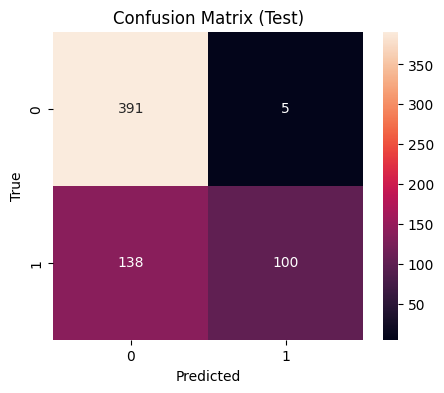

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
logits = model(data.x, data.edge_index)
preds  = logits.argmax(dim=1)

mask = (data.test_mask) & (data.y != -1)
y_true, y_pred = data.y[mask].cpu(), preds[mask].cpu()

print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 🕵️‍♂️ Интерпретация предсказаний с **GNNExplainer**
Выберем произвольный корректно классифицированный узел из тестовой выборки и посмотрим, какие рёбра и признаки были наиболее важны для модели.

## 💾 Сохранение обученной модели

In [25]:
MODEL_PATH = Path('./checkpoints/gcn_model.pt')
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f'Модель сохранена в {MODEL_PATH.resolve()}')

Модель сохранена в /Users/a1234/Fraud/gnn/checkpoints/gcn_model.pt
